#### This script imports all Confitional CRF's for each subject and the results are visualized in this script when all CRF's are averaged
##### tip: use esc + z to recover accidentally deleted cell

In [45]:
# load packages
import numpy as np 
import h5py
import scipy.io
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime

In [46]:
NumBins = 6 # number of contrasts
NumHarms = 2 # number of harmonic data: 2F1, 4F1
NumComp = 0 # first component from RCA
NumConds = 4
dk_labs = ['attnL F1','attnL F2','attnR F1','attnR F2',]
contrast_levels=np.array([1, 3, 5, 16, 40, 100])
contrast_levels_labs=['1%', '3%', '5%', '16%', '40%', '100%']

In [47]:
def GrandCRF(data):
    """This function computes the average by stacking [12x2]
    arrays along 0th dim and then average across the 0th dimension"""
    TotSubs = list(data.values())
    temp = np.stack(TotSubs, axis = 0) # [Subj x 12r x 2c]
    dOut = np.mean(temp, axis = 0)
    return dOut

def OmitData(SubNames, noisySub_arr):
    """"This function finds and removes a participants data for all files
    returns a np.array with the positions to omit from the grand average
    of CRF
    ######################################################################
    SubNames = list of subject names
    noisySub_arr = array that must be smaller than the size of SubNames"""
    nS_array = np.array(noisySub_arr)
    omit = np.where(SubNames == nS_array[:,None])[1]
    return omit


In [48]:
cp1 = sns.color_palette("husl", 8)
cp2 = sns.color_palette("hls", 8)

In [49]:
# Main Directory of processed file from MatLab
MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[-1] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['F1AverageCRF_20240205_154708.pkl', 'F1AverageCRF_20240205_162024.mat', 'F1AverageCRF_20240205_162024.pkl', 'F1AverageCRF_20240206_104806.pkl', 'F1AverageCRF_20240207_124816.pkl', 'AllCondCRF_AllSess_20240210_1038.pkl', 'AllCondCRF_AllSess_20240211_1701.pkl', 'AllCondCRF_AllSess_20240212_1128.pkl']
Current WD: D:\AttnXV3_analysis\RCA_F1\AvgCRFs\AllCondCRF_AllSess_20240212_1128.pkl
Does File #1 Exist? True


In [50]:
loadData = pkl.load(open(file_path1,'rb'))
print(loadData.keys())

dict_keys(['Data', 'SubNames', 'VoiceMemo', 'DictMainKeys', 'ContLevs', 'crfLabs'])


In [51]:
data = loadData['Data']
data_labels = loadData['DictMainKeys']
SubNames = np.array(loadData['SubNames'])
note = loadData['VoiceMemo']
contrast_levels = loadData['ContLevs']
contrast_labs = loadData['crfLabs']
print(note)

['This file contains all subjects who did both sessions, avg of CRF [12x2] array, original crfs']


#### Use this if planning on excluding participants / grouping subj responses

In [52]:
noisySub = ['2651','2652', '2671' ,'2668','2696']
#sub, counts = (np.unique(rmv, return_counts = True))
#print(sub[counts >1])
noisySub = np.sort(noisySub)
omit = OmitData(SubNames,noisySub)
omit = np.array(omit)
print(f'Subjects Data to omit: {SubNames[omit]}')
GoodSubjs = np.ones((int(len(SubNames))))
GoodSubjs[omit] = 0 # index to process subj data
print(GoodSubjs)

Subjects Data to omit: ['2651' '2652' '2668' '2671' '2696']
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 1.]


#### Remove Subjects from Average Contrast Response Function

In [53]:
cleanData = {}

for co in range(NumConds):
    if co not in cleanData:
        cleanData[co] = {}
    for sub in range(len(SubNames)):
        xIn = data[co][sub] # 12 x 2
        pos = GoodSubjs[sub]
        if pos == 1:
            #print(f'keep {SubNames[sub]}')
            cleanData[co][sub] = xIn
        #else: 
            #print(f'removing subject {SubNames[sub]}')
print(f'Analysis Reduced to {len(cleanData[0].keys())} subjects, total {len(SubNames)}')

Analysis Reduced to 20 subjects, total 25


### 2 Options for plotting: Everyones CRF's / Select Subjects CRF's...

In [54]:
avgCRF_ori = {}
avgCRF_clean = {}
for c in range(4):#(NumConds):
    avgCRF_ori[c]= GrandCRF(data = data[c]) # all participants data
    avgCRF_clean[c]= GrandCRF(data = cleanData[c]) # select participants 
#print(avgCRF[0].shape)

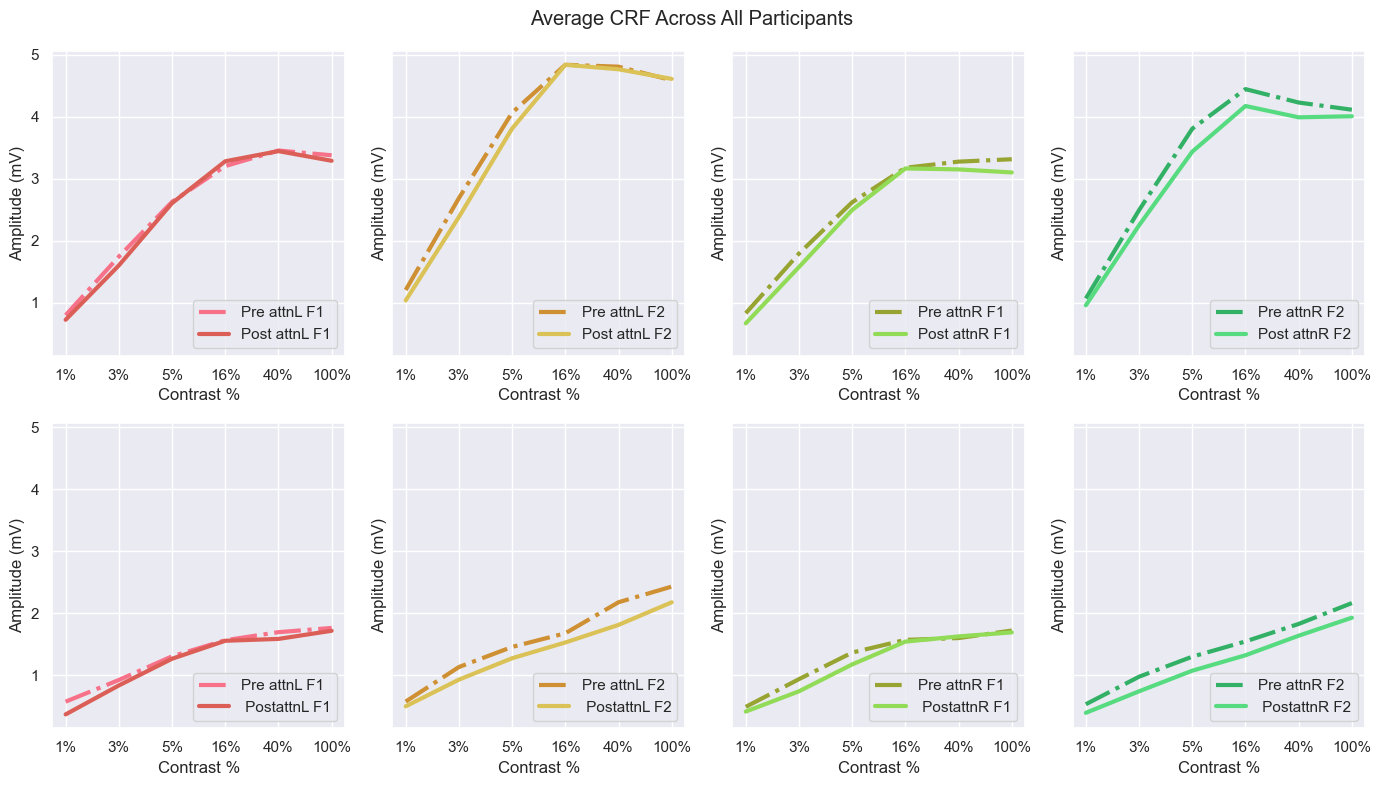

In [55]:
sns.set_theme()
fig, axs = plt.subplots(2,4, figsize=(14,8), sharey = True)

for col in range(NumConds):
    d_In = avgCRF_ori[col]
    axs[0,col].plot(d_In[:6,0],label = f'Pre {dk_labs[col]}', color = cp1[col],linewidth = 3, linestyle = '-.')
    axs[0,col].plot(d_In[:6,1:],label = f'Post {dk_labs[col]}', color = cp2[col],linewidth = 3)

    axs[1,col].plot(d_In[6:,0],label = f'Pre {dk_labs[col]}', color = cp1[col],linewidth = 3, linestyle = '-.')
    axs[1,col].plot(d_In[6:,1],label = f' Post{dk_labs[col]}', color = cp2[col],linewidth = 3)

    axs[0,col].set_xlabel('Contrast %')
    axs[0,col].set_ylabel('Amplitude (mV)')
    axs[0,col].legend(loc = 'lower right')

    axs[1,col].set_xlabel('Contrast %')
    axs[1,col].set_ylabel('Amplitude (mV)')
    axs[1,col].legend(loc = 'lower right')

    axs[0,col].legend(loc = 'lower right')
    axs[0,col].set_xticks(range(len(contrast_levels_labs)))
    axs[0,col].set_xticklabels(contrast_levels_labs)
    axs[1,col].set_xticks(range(len(contrast_levels_labs)))
    axs[1,col].set_xticklabels(contrast_levels_labs)

plt.suptitle('Average CRF Across All Participants')
plt.tight_layout()

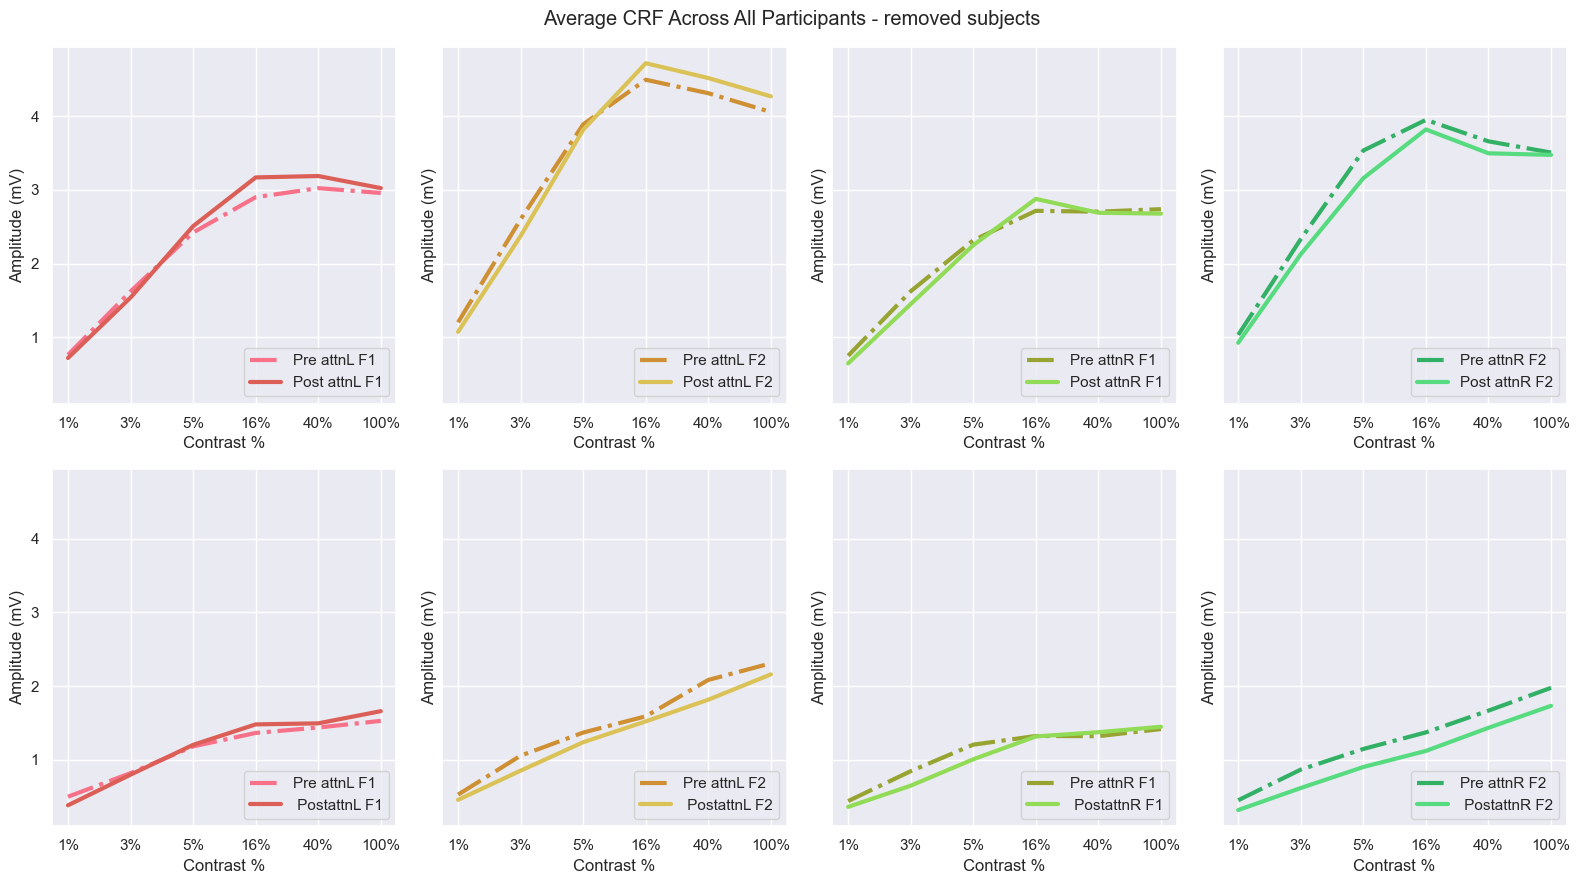

In [56]:
sns.set_theme()
fig, axs = plt.subplots(2,4, figsize=(16,9), sharey = True)

for col in range(NumConds):
    d_In = avgCRF_clean[col]
    axs[0,col].plot(d_In[:6,0],label = f'Pre {dk_labs[col]}', color = cp1[col],linewidth = 3, linestyle = '-.')
    axs[0,col].plot(d_In[:6,1:],label = f'Post {dk_labs[col]}', color = cp2[col],linewidth = 3)

    axs[1,col].plot(d_In[6:,0],label = f'Pre {dk_labs[col]}', color = cp1[col],linewidth = 3, linestyle = '-.')
    axs[1,col].plot(d_In[6:,1],label = f' Post{dk_labs[col]}', color = cp2[col],linewidth = 3)

    axs[0,col].set_xlabel('Contrast %')
    axs[0,col].set_ylabel('Amplitude (mV)')
    axs[0,col].legend(loc = 'lower right')

    axs[1,col].set_xlabel('Contrast %')
    axs[1,col].set_ylabel('Amplitude (mV)')
    axs[1,col].legend(loc = 'lower right')

    axs[0,col].legend(loc = 'lower right')
    axs[0,col].set_xticks(range(len(contrast_levels_labs)))
    axs[0,col].set_xticklabels(contrast_levels_labs)
    axs[1,col].set_xticks(range(len(contrast_levels_labs)))
    axs[1,col].set_xticklabels(contrast_levels_labs)

plt.suptitle('Average CRF Across All Participants - removed subjects')
plt.tight_layout()

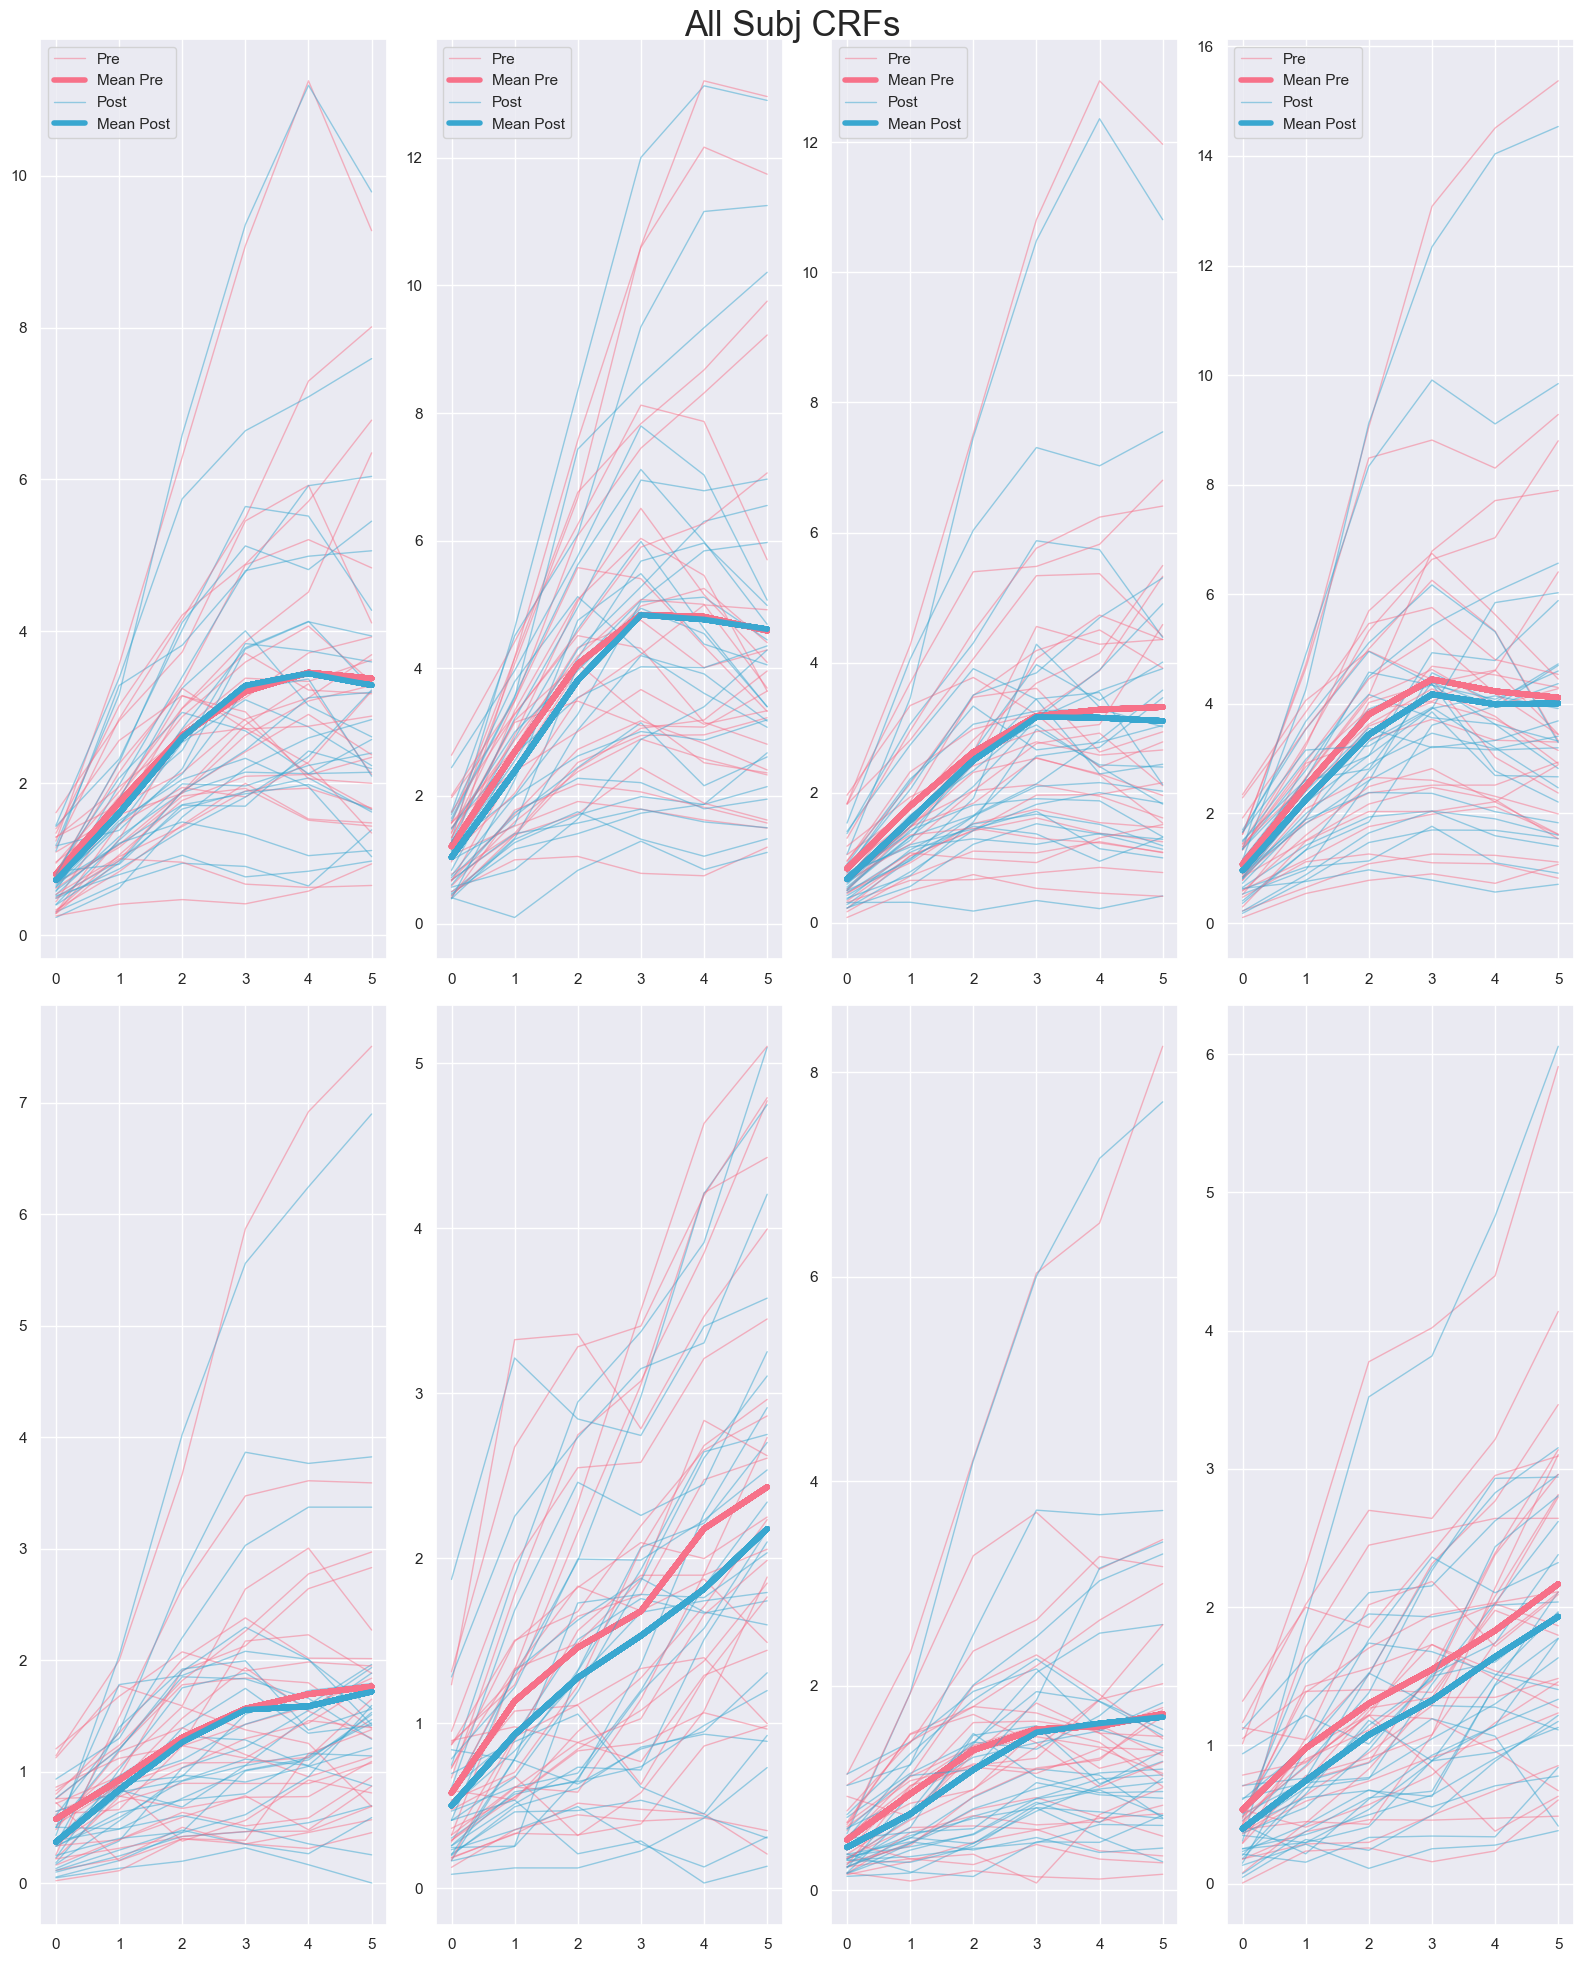

In [102]:
pre = 1
post = 0
ss = 0
sse = 6
counter = 0 

fig,axs = plt.subplots(2,4, figsize = (16,20), sharey = False)
for co in data.keys(): # 4
        dIn = data[co] # each subjects crf
        avg_data = avgCRF_ori[co] # avgeraged crf
        for subiter in dIn.keys(): # all subjects
                xIn = dIn[subiter]
                for t in range(2):
                        if t == 0:
                                lab = 'pre'
                        else:
                                lab = 'post'        
                        axs[0,co].plot(xIn[:sse,t], color =  cp1[t*5], alpha = 0.5, linewidth = 1)
                        axs[1,co].plot(xIn[sse:,t], color =  cp1[t*5], alpha = 0.5, linewidth = 1)
                        axs[0,co].plot(avg_data[:sse,t], color =  cp1[t*5], label = lab, linewidth = 4)
                        axs[1,co].plot(avg_data[sse:,t],color =  cp1[t*5], label = lab, linewidth = 4) # plot pre and post via t 
                        #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp1[t])
                        #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp2[t])
                        axs[0,co].legend(labels = ['Pre','Mean Pre','Post','Mean Post'], loc = 'upper left')
plt.suptitle(f'All Subj CRFs', fontsize = 25)
plt.tight_layout()

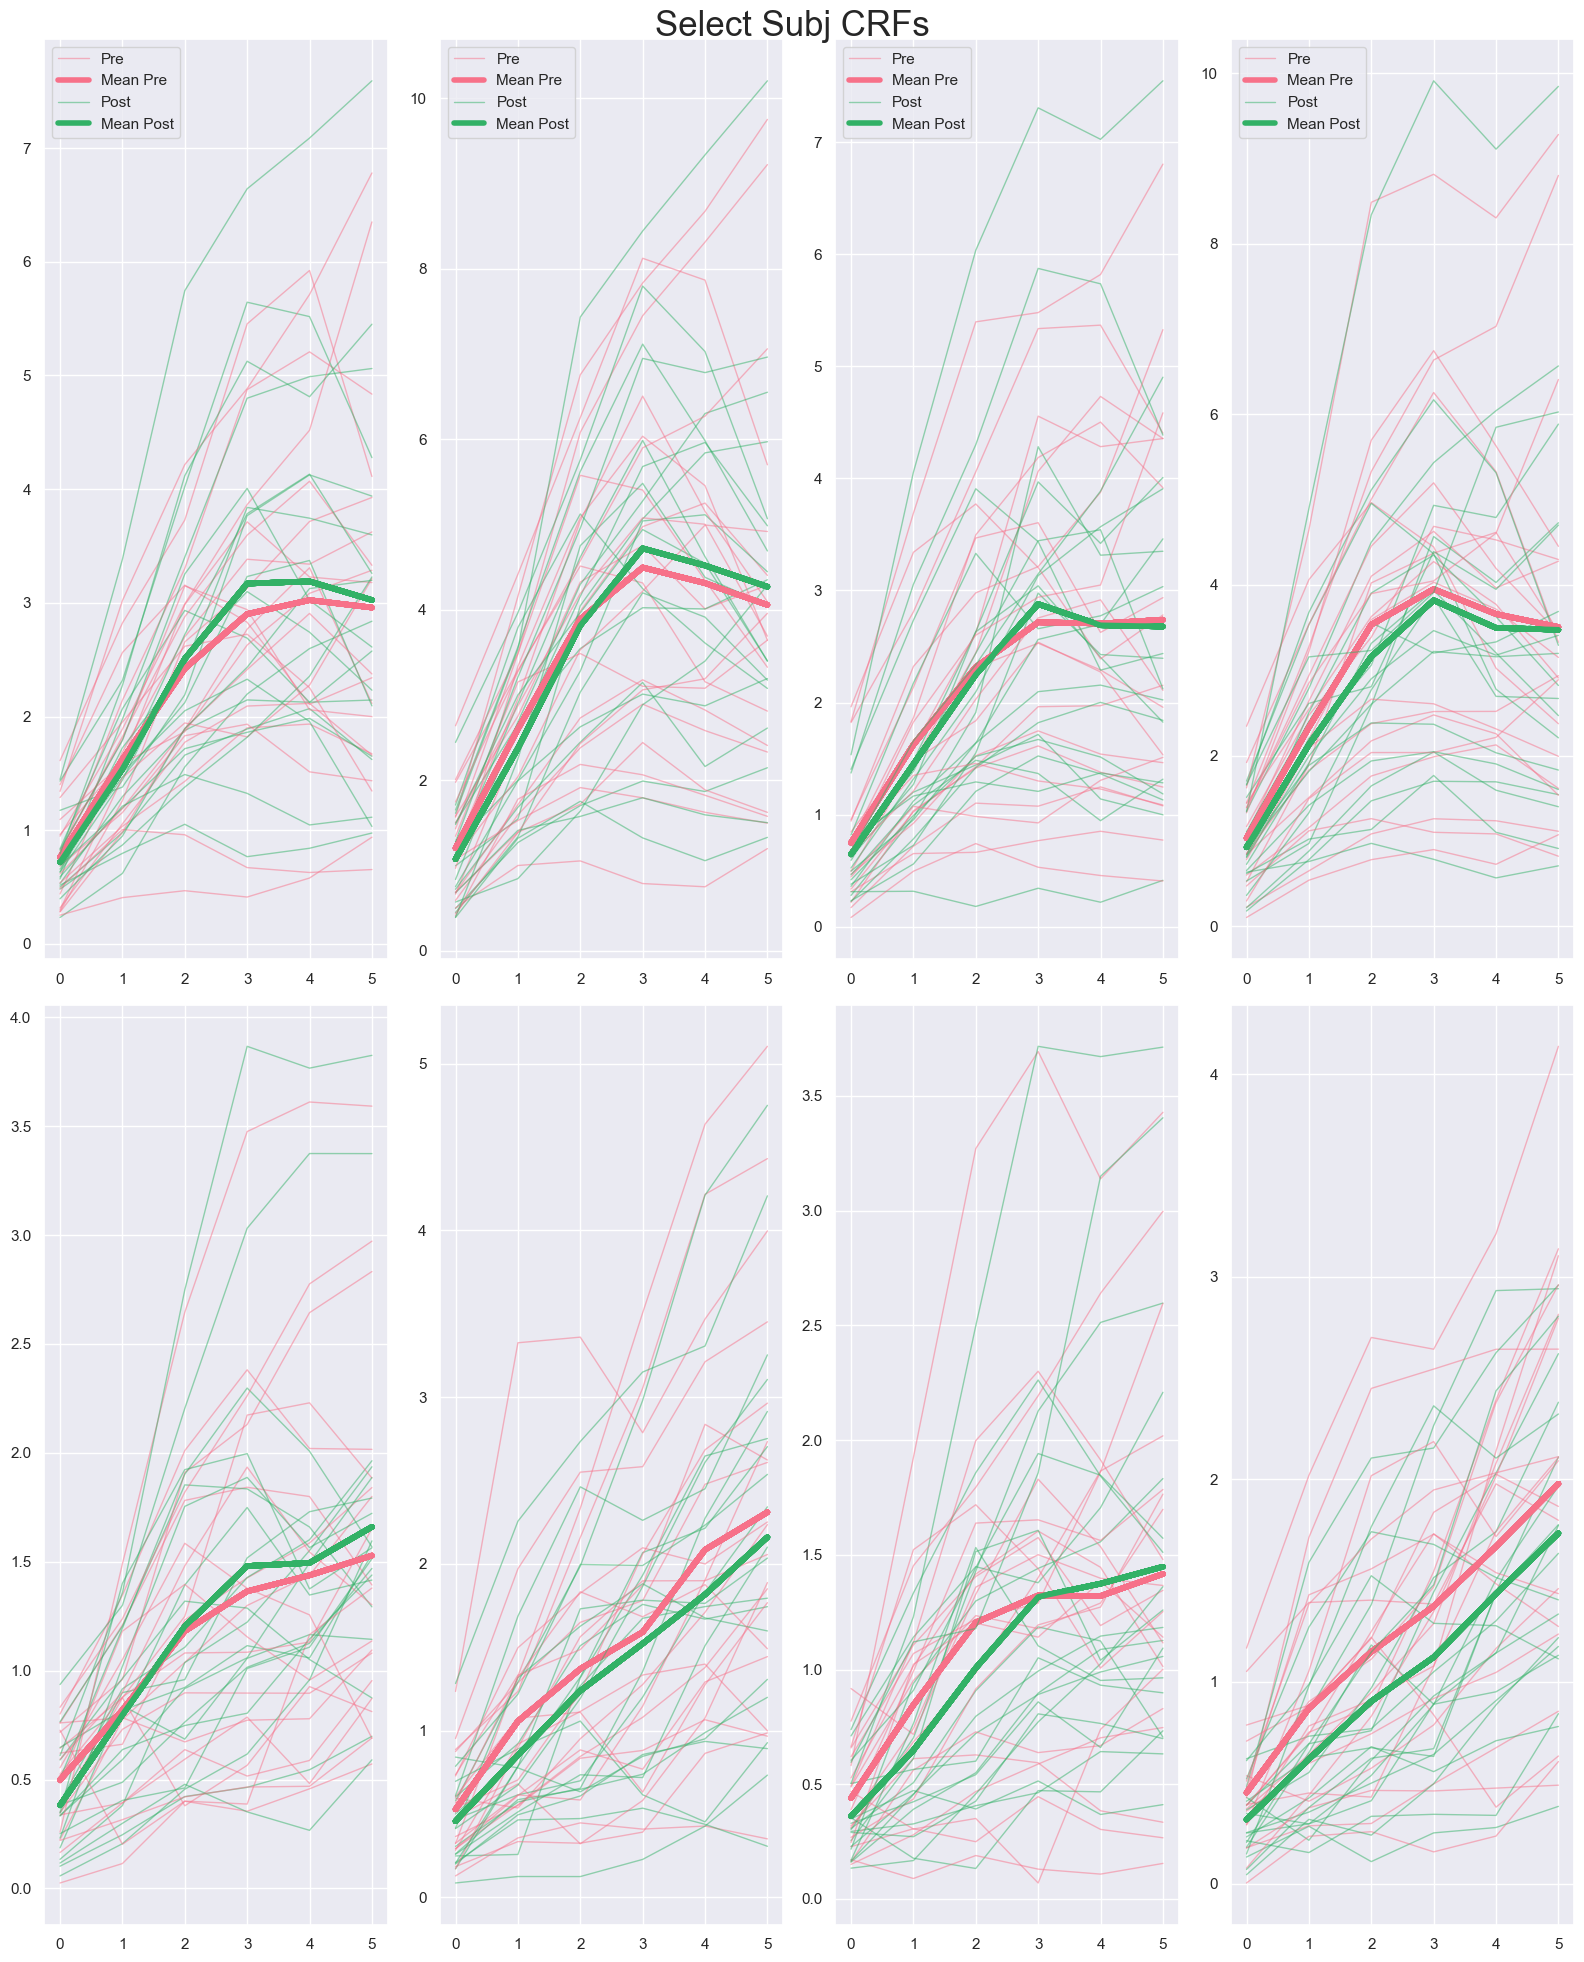

In [103]:
pre = 1
post = 0
ss = 0
sse = 6
counter = 0 

fig,axs = plt.subplots(2,4, figsize = (16,20), sharey = False)
for co in data.keys(): # 4
        dIn = cleanData[co] # each subjects crf
        avg_data = avgCRF_clean[co] # avgeraged crf
        for subiter in dIn.keys(): # all subjects
                xIn = dIn[subiter]
                for t in range(2):
                        if t == 0:
                                lab = 'pre'
                        else:
                                lab = 'post'
                        axs[0,co].plot(xIn[:sse,t], color = cp1[t*3], label = lab, alpha = 0.5, linewidth = 1)
                        axs[0,co].plot(avg_data[:sse,t], color = cp1[t*3], linewidth = 4)
                        axs[1,co].plot(xIn[sse:,t], color = cp1[t*3], label = lab, alpha = 0.5, linewidth = 1)
                        axs[1,co].plot(avg_data[sse:,t],color = cp1[t*3], linewidth = 4) # plot pre and post via t 
                        #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp1[t])
                        #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp2[t])
                        axs[0,co].legend(labels = ['Pre','Mean Pre','Post','Mean Post'], loc = 'upper left')
plt.suptitle(f'Select Subj CRFs', fontsize = 25)
plt.tight_layout()

In [ ]:
### %history use this if you delete ur cell code and its recent ...
### cntrl and / hashtags many lines of code at once 
#### This script imports all Confitional CRF's for each subject and the results are visualized in this script when all CRF's are averaged
##### tip: use esc + z to recover accidentally deleted cell

In [ ]:
# pre = 1
# post = 0
# ss = 0
# sse = 6
# counter = 0 
# labels = []
# fig,axs = plt.subplots(2,4, figsize = (16,8), sharey = True)
# for co in data.keys(): # 4
#         dIn = data[co]
#         for subiter in dIn.keys(): # all subjects
#                 xIn = dIn[subiter]
#                 for t in range(2):
#                         if t == 0:
#                                 lab = 'pre'
#                         else:
#                                 lab = 'post'
#                         labels.append(lab)
#                         axs[0,co].plot(xIn[:sse,t], color = cp1[t*5], label = lab)
#                         axs[1,co].plot(xIn[sse:,t], color = cp1[t*5], label = lab)#
#                         #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp1[t])
#                         #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp2[t])
#                         axs[0,co].legend(labels = labels[0:2], loc = 'upper left')
# plt.suptitle(f'All Subj CRFs')
# plt.tight_layout()
# ###########################################################################################
# labels = []
# fig,axs = plt.subplots(2,4, figsize = (16,8), sharey = True)
# for co in cleanData.keys(): # 4
#         dIn = cleanData[co]
#         for subiter in dIn.keys(): # all subjects
#                 xIn = dIn[subiter]
#                 for t in range(2):
#                         if t == 0:
#                                 lab = 'pre'
#                         else:
#                                 lab = 'post'
#                         labels.append(lab)
#                         axs[0,co].plot(xIn[:sse,t], color = cp1[t*5], label = lab)
#                         axs[1,co].plot(xIn[sse:,t], color = cp1[t*5], label = lab)#
#                         #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp1[t])
#                         #axs[t,co].plot(xIn[ss+(sse*t):sse*(t+1),t], color = cp2[t])
#                         axs[0,co].legend(labels = labels[0:2], loc = 'upper left')
# plt.suptitle(f'Select CRFs')
# plt.tight_layout()